# Validate CNN CHM with airborne lidar grids (LVIS): 
### intersection and multiprocessing data frames
Paul Montesano  
June 2023

In [1]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import show

import fiona
import geopandas as gpd
import pandas as pd
import numpy as np
import folium

import contextily as ctx

import os
import sys
import glob
sys.path.append('/home/pmontesa/code/pygeotools')
from pygeotools.lib import *

sys.path.append('/home/pmontesa/code/geoscitools')
import footprintlib
import vhrlib
import maplib

# This is a private repo
sys.path.append('/home/pmontesa/code/dgtools')
from dgtools.lib import dglib

# 
sys.path.append('/home/pmontesa/code/above-shrubs')
import notebooks.predlib

import random
import shapely
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plotnine
from plotnine import *

import sklearn.metrics as metrics

In [2]:
import importlib
importlib.reload(footprintlib)

<module 'footprintlib' from '/home/pmontesa/code/geoscitools/footprintlib.py'>

In [3]:
from multiprocessing import Pool
from functools import partial

### Paths from August 2023 work

In [ ]:
OUT_SUBDIR = 'cnn-chm-v2-noAug-invSqrt'
dir_main = '/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/products'

### Paths from Sept 2023 work

In [4]:
# NOTE - we should organize our various main dirs so that the structures are the same - this makes the code easier to run
OUT_CHM_SUBSET = 'products_merged_nodtm_nontrain_strips' #  <---- 
OUT_CHM_SUBSET = 'dm_10m'

OUT_CHM = '20231014_chm'
dir_main = f'/home/pmontesa/mmacande/srlite/chm_model/{OUT_CHM}'
dir_main = f'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/{OUT_CHM}'
dir_main

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm'

## Setup Paths from Sept-Dec 2025 work with DinoV3

In [14]:
OUT_CHM = '4.3.2.5'
OUT_CHM_SUBSET = '002m'
dir_main = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs'
dir_chm =           f'{dir_main}/development/chm/dinov3/{OUT_CHM}'
dir_validate_main = f'{dir_main}/validation/chm/dinov3/{OUT_CHM}/{OUT_CHM_SUBSET}'
!mkdir -p $dir_validate_main
dir_validate_main

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/validation/chm/dinov3/4.3.2.5/002m'

## Setup Paths - orig work

In [3]:
dir_chm = f'{dir_main}/{OUT_CHM_SUBSET}'

dir_validate_main =   f'{dir_chm}/validate' # validation subdirs will sit here
!mkdir -p $dir_validate_main
dir_footprints = f'{dir_chm}/footprints'
!mkdir -p $dir_footprints

dir_validate_main

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/validate'

In [4]:
dir_chm

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m'

In [8]:
f_list = glob.glob(dir_chm + '/*.tif')
len(f_list)

946

In [9]:
f_list[0]

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/WV03_20200704_M1BS_104001005CC4E300-chm-dm-10m.tif'

In [15]:
nowtime = pd.Timestamp.now().strftime('%Y%m%d')
nowtime

'20260102'

### Build CHM footprints

In [10]:
%%time
# Make footprint gdfs of the the filenames, concat to single gdf
if False:
    f_gdf_lst = [footprintlib.raster_footprint(r_fn, DO_DATAMASK=False, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True) for r_fn in f_list]
else:
    with Pool(processes=35) as pool:
        f_gdf_lst = pool.map(partial(footprintlib.raster_footprint, DO_DATAMASK=False, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True), f_list)

CPU times: user 259 ms, sys: 312 ms, total: 571 ms
Wall time: 4.16 s


In [11]:
footprint_gdf_chm = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME='', DROP_DUPLICATES=True)
footprint_gdf_chm = footprintlib.get_attributes_from_filename(footprint_gdf_chm, 'cnn-chm-v1', '-sr-02m.cnn-chm-v1')
footprint_gdf_chm.info()

Building GDF from list...
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 946 entries, 0 to 945
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   file            946 non-null    object        
 1   geometry        946 non-null    geometry      
 2   footprint_name  946 non-null    object        
 3   path            946 non-null    object        
 4   area_km2        946 non-null    float64       
 5   area_ha         946 non-null    float64       
 6   type            946 non-null    object        
 7   catid           946 non-null    object        
 8   sensor          946 non-null    object        
 9   year            946 non-null    int64         
 10  month           946 non-null    int64         
 11  date            946 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), geometry(1), int64(2), object(6)
memory usage: 96.1+ KB


<Axes: >

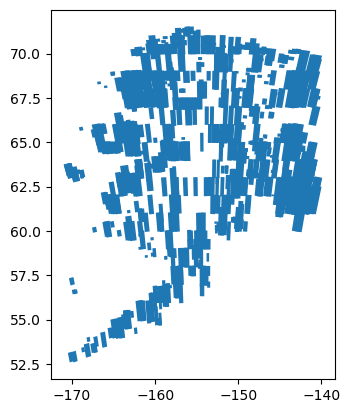

In [12]:
footprint_gdf_chm.cx[-170:-130,50:90].plot()

### Save the CHM footprints Geodataframe

In [220]:
footprint_gdf_chm.to_file(os.path.join(dir_footprints, f'footprints_chm_{nowtime}.gpkg'), driver='GPKG')

### Read the CHM footprints in

In [13]:
footprint_gdf_chm = gpd.read_file('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/footprints/footprints_chm_20231023.gpkg')

### Read the CHM footprints in (from DinoV3 CHM)

In [7]:
footprint_gdf_chm = gpd.read_file('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_chm_dinov3_4.3.2.5.gpkg')

### Read in LVIS footprints

In [8]:
# Open the LVIS file, which has multiple layers based on year
foot_lvis_fn = os.path.join('/explore/nobackup/people/pmontesa/userfs02/arc/_footprints', 'footprints_lvis_above.gpkg')
gdf_list = []
for layername in fiona.listlayers(foot_lvis_fn):
    gdf_list.append(gpd.read_file(foot_lvis_fn, layer=layername))
foot_lvis = pd.concat(gdf_list, ignore_index=True).to_crs(4326)
foot_lvis.columns = [x.lower() for x in foot_lvis.columns]

In [9]:
foot_lvis.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3579 entries, 0 to 3578
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   dn        3579 non-null   float64 
 1   file      3579 non-null   object  
 2   path      3579 non-null   object  
 3   geometry  3579 non-null   geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 112.0+ KB


In [10]:
foot_lvis.head()

,dn,file,path,geometry
0,1.0,LVIS2_ABoVE2017_0714_R1803_082427_lvis_pt_cnt_...,/att/nobackup/pmontesa/userfs02/data/LVIS/2017...,"MULTIPOLYGON (((-150.45189 67.02011, -150.4523..."
1,1.0,LVIS2_ABoVE2017_0715_R1803_073357_lvis_pt_cnt_...,/att/nobackup/pmontesa/userfs02/data/LVIS/2017...,"MULTIPOLYGON (((-147.01385 66.21919, -147.0079..."
2,1.0,LVIS2_ABoVE2017_0630_R1803_088149_lvis_pt_cnt_...,/att/nobackup/pmontesa/userfs02/data/LVIS/2017...,"MULTIPOLYGON (((-127.69681 66.30509, -127.6956..."
3,1.0,LVIS2_ABoVE2017_0714_R1803_096555_lvis_pt_cnt_...,/att/nobackup/pmontesa/userfs02/data/LVIS/2017...,"MULTIPOLYGON (((-140.74901 68.69402, -140.7472..."
4,1.0,LVIS2_ABoVE2017_0714_R1803_089168_lvis_pt_cnt_...,/att/nobackup/pmontesa/userfs02/data/LVIS/2017...,"MULTIPOLYGON (((-148.5983 69.62141, -148.5972 ..."


### Overlay LVIS with CHM footprints

In [11]:
%%time
foot_intersect_chm_lvis = gpd.overlay(footprint_gdf_chm, foot_lvis.to_crs(footprint_gdf_chm.crs), how='intersection')

CPU times: user 4min 15s, sys: 796 ms, total: 4min 16s
Wall time: 4min 17s


### Save the Validation Intersection Geodataframe

In [16]:
foot_intersect_chm_lvis.to_file(os.path.join(dir_validate_main, f'val_intersect_footprints_LVIS_{nowtime}.gpkg'), driver='GPKG')

### Read the Intersection footprints back in

In [5]:
#foot_intersect_chm_lvis = gpd.read_file(dir_validate_main + '/val_intersect_footprints_LVIS_20231023.gpkg')

/home/pmontesa/.conda/envs/boreal_forest_gpu/lib/python3.7/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [ ]:
import hvplot.pandas  # noqa

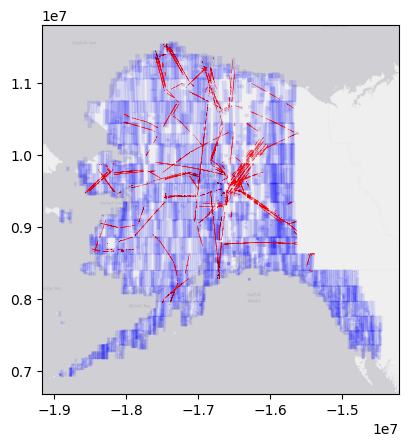

In [17]:
ax = footprint_gdf_chm.cx[-170:-130,50:90].to_crs(3857).plot(color='blue', alpha=0.1)
ax = foot_intersect_chm_lvis.cx[-170:-130,50:90].to_crs(3857).plot(color='red', ax=ax)
ax = ctx.add_basemap(ax, crs=3857, source = ctx.providers.Esri.WorldGrayCanvas, attribution=' ' )

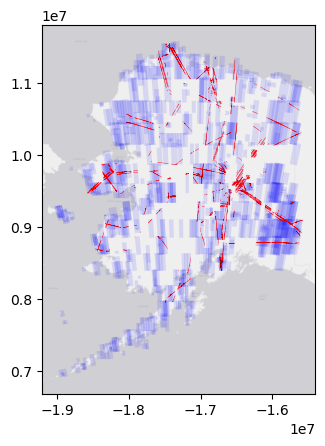

In [16]:
ax = footprint_gdf_chm.cx[-170:-130,50:90].to_crs(3857).plot(color='blue', alpha=0.1)
ax = foot_intersect_chm_lvis.cx[-170:-130,50:90].to_crs(3857).plot(color='red', ax=ax)
ax = ctx.add_basemap(ax, crs=3857, source = ctx.providers.Esri.WorldGrayCanvas, attribution=' ' )

# Get all corresponding filenames for validation
for LVIS and predictions


In [18]:
foot_intersect_chm_lvis.head()

,file_1,footprint_name,path_1,area_km2,area_ha,type,catid,sensor,year,month,date,year_cat,month_cat,dn,file_2,path_2,geometry
0,WV02_20160609_M1BS_10300100570AC500-sr-02m.chm...,WV02_20160609_M1BS_10300100570AC500,/explore/nobackup/projects/above/misc/ABoVE_Sh...,3863.37496,386337.496,$CHM_{SR}$,10300100570AC500,WV02,2016,6,2016-06-09,2016,6,1.0,LVISF2_ABoVE2019_0729_R2003_080661_lvis_pt_cnt...,/att/nobackup/pmontesa/userfs02/data/LVIS/2019...,"MULTIPOLYGON (((-151.50964 68.72032, -151.5094..."
1,WV02_20160612_M1BS_1030010057A6E600-sr-02m.chm...,WV02_20160612_M1BS_1030010057A6E600,/explore/nobackup/projects/above/misc/ABoVE_Sh...,4070.50968,407050.968,$CHM_{SR}$,1030010057A6E600,WV02,2016,6,2016-06-12,2016,6,1.0,LVIS2_ABoVE2017_0714_R1803_086577_lvis_pt_cnt_...,/att/nobackup/pmontesa/userfs02/data/LVIS/2017...,"MULTIPOLYGON (((-151.38797 69.74423, -151.3869..."
2,WV02_20160612_M1BS_1030010057A6E600-sr-02m.chm...,WV02_20160612_M1BS_1030010057A6E600,/explore/nobackup/projects/above/misc/ABoVE_Sh...,4070.50968,407050.968,$CHM_{SR}$,1030010057A6E600,WV02,2016,6,2016-06-12,2016,6,1.0,LVIS2_ABoVE2017_0714_R1803_086720_lvis_pt_cnt_...,/att/nobackup/pmontesa/userfs02/data/LVIS/2017...,"MULTIPOLYGON (((-151.20381 69.62426, -151.2049..."
3,WV02_20160612_M1BS_1030010057A6E600-sr-02m.chm...,WV02_20160612_M1BS_1030010057A6E600,/explore/nobackup/projects/above/misc/ABoVE_Sh...,4070.50968,407050.968,$CHM_{SR}$,1030010057A6E600,WV02,2016,6,2016-06-12,2016,6,1.0,LVIS2_ABoVE2017_0714_R1803_085223_lvis_pt_cnt_...,/att/nobackup/pmontesa/userfs02/data/LVIS/2017...,"POLYGON ((-151.59421 69.61398, -151.59136 69.6..."
4,WV02_20160612_M1BS_1030010057A6E600-sr-02m.chm...,WV02_20160612_M1BS_1030010057A6E600,/explore/nobackup/projects/above/misc/ABoVE_Sh...,4070.50968,407050.968,$CHM_{SR}$,1030010057A6E600,WV02,2016,6,2016-06-12,2016,6,1.0,LVIS2_ABoVE2017_0714_R1803_085306_lvis_pt_cnt_...,/att/nobackup/pmontesa/userfs02/data/LVIS/2017...,"MULTIPOLYGON (((-151.8152 69.43887, -151.81516..."


In [16]:
# f = glob.glob(f'{dir_footprints}/footprint_overlay_lvis_*.gpkg')[0]
# lvis_pred_SUBSET = gpd.read_file(f, driver='GPKG')

### Unique set of strips for validation

In [19]:
val_strips = set(foot_intersect_chm_lvis.footprint_name.to_list())
len(val_strips)

1250

### Get VHR metadata for these val strips
helps to understand results?


In [19]:
OUTDIR_SRLITE = '/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1'
TARGET = 'alaska*'
TARGET_DIR_TOA = f'{OUTDIR_SRLITE}/toa/{TARGET}'
#SEARCH_STRING = '/split_*/5-toas/*.xml'
SEARCH_STRING = '/**/*.xml'
f_list_toa_xml = glob.glob(f"{TARGET_DIR_TOA}{SEARCH_STRING}", recursive=True)
len(f_list_toa_xml)

78

#### vhr metadata

In [12]:
%%time

import importlib
importlib.reload(vhrlib)

with Pool(processes=35) as pool:
    vhr_df_list = pool.map(partial(vhrlib.make_vhr_xml_dataframe), f_list_toa_xml)
vhr_df = pd.concat(vhr_df_list)
vhr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3419 entries, 0 to 0
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   satid       3419 non-null   object             
 1   catid       3419 non-null   object             
 2   tlctime     3419 non-null   datetime64[ns, UTC]
 3   gsd         3419 non-null   float64            
 4   sunaz       3419 non-null   float64            
 5   sunel       3419 non-null   float64            
 6   az          3419 non-null   float64            
 7   el          3419 non-null   float64            
 8   intrack     3419 non-null   float64            
 9   crosstrack  3419 non-null   float64            
 10  offnadir    3419 non-null   float64            
 11  cloudcover  3419 non-null   float64            
 12  scandir     3419 non-null   object             
 13  ULLON       3419 non-null   float64            
 14  ULLAT       3419 non-null   float64        

In [230]:
[strip for strip in val_strips if 'AC3100' in strip]

[]

## Get matched lists of paths of predicted CHMs and reference CHMs

In [231]:
foot_intersect_chm_lvis.head(2)

,file_1,footprint_name,path_1,area_km2,area_ha,type,catid,sensor,year,month,date,dn,file_2,path_2,geometry
0,WV02_20140802_M1BS_10300100342CF900-chm-dm-10m...,WV02_20140802_M1BS_10300100342CF900-chm-dm-10m...,/explore/nobackup/projects/above/misc/ABoVE_Sh...,2979.0468,297904.68,cnn-chm-v1,10300100342CF900-chm-dm-10m.tif,WV02,2014,8,2014-08-02,1.0,LVISF2_ABoVE2019_0723_R2003_066782_lvis_pt_cnt...,/att/nobackup/pmontesa/userfs02/data/LVIS/2019...,"MULTIPOLYGON (((-155.25904 59.13565, -155.2586..."
1,WV02_20180701_M1BS_103001007F059300-chm-dm-10m...,WV02_20180701_M1BS_103001007F059300-chm-dm-10m...,/explore/nobackup/projects/above/misc/ABoVE_Sh...,2027.7864,202778.64,cnn-chm-v1,103001007F059300-chm-dm-10m.tif,WV02,2018,7,2018-07-01,1.0,LVISF2_ABoVE2019_0723_R2003_066782_lvis_pt_cnt...,/att/nobackup/pmontesa/userfs02/data/LVIS/2019...,"MULTIPOLYGON (((-155.25904 59.13565, -155.2586..."


In [20]:
#pred_stack_list = sorted(list(set(lvis_pred_tte.file.to_list())))
foot_intersect_chm_lvis["pred_path"] = foot_intersect_chm_lvis["path_1"] + '/' + foot_intersect_chm_lvis["file_1"]
pred_path_list = foot_intersect_chm_lvis.pred_path.to_list()
print(f'{len(list(set(pred_path_list)))} individual chm predictions from srlite available for validation.')
pred_path_list[0:5]

488 individual chm predictions from srlite available for validation.


['/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/WV02_20140802_M1BS_10300100342CF900-chm-dm-10m.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/WV02_20180701_M1BS_103001007F059300-chm-dm-10m.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/WV02_20180701_M1BS_1030010080C0E600-chm-dm-10m.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/WV03_20200729_M1BS_104001005E8CBF00-chm-dm-10m.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/WV03_20190817_M1BS_1040010051769700-chm-dm-10m.tif']

In [21]:
foot_intersect_chm_lvis["lvis_path"] = foot_intersect_chm_lvis["path_2"].str.replace('/att/nobackup','/explore/nobackup/people') + '/' + foot_intersect_chm_lvis["file_2"]
lvis_path_list = [f.replace('lvis_pt_cnt', 'RH098_mean') for f in foot_intersect_chm_lvis.lvis_path.to_list()]
print(f'{len(list(set(lvis_path_list)))} individual LVIS flightlines being used for validation.')
lvis_path_list[0:5]

913 individual LVIS flightlines being used for validation.


['/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0723_R2003_066782_RH098_mean_30m.tif',
 '/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0723_R2003_066782_RH098_mean_30m.tif',
 '/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0723_R2003_066782_RH098_mean_30m.tif',
 '/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0723_R2003_066782_RH098_mean_30m.tif',
 '/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0723_R2003_066782_RH098_mean_30m.tif']

In [22]:
print(f'{len(pred_path_list)} unique intersections (predicted CNN CHM X LVIS) available for validation.')

2968 unique intersections (predicted CNN CHM X LVIS) available for validation.


# Validation of stacks with LVIS
1. Use the corresponding filenams: pred_fn , lvis_fn
2. select a random set of a few stacks  
3. validate the portion of this stack that intersects with LVIS 

### Map a single random validation site

In [23]:

if True:
    # Random test
    IMG_IDX = random.sample(range(0,len(lvis_path_list)), 1)[0]
else:
    # Selected test
    IMG_IDX = [i for i,x in enumerate(lvis_path_list) if 'R1803_068540' in x][0]

print(IMG_IDX)

test_gdf = foot_intersect_chm_lvis.iloc[IMG_IDX:IMG_IDX+1].drop(columns=['date'])
test_gdf.explore(color='red', tiles=maplib.basemap_xyz_url['esri_imagery'], attr=' ', height='50%')

590


In [24]:
import importlib
importlib.reload(notebooks.predlib)

<module 'notebooks.predlib' from '/home/pmontesa/code/above-shrubs/notebooks/predlib.py'>

### Plots for that single random validation site

In [25]:
df_test = notebooks.predlib.validate_chm_pred(pred_path_list[IMG_IDX], lvis_path_list[IMG_IDX], 'RH075', scale_factor=1, RETURN_DF=True, DST_NDV=None, DEBUG=True)

Calculating slope from DEM...
WV02_20200707_M1BS_10300100A84C9800-chm-dm-10m.tif
LVIS2_ABoVE2017_0706_R1803_063407_RH075_mean_30m.tif
LVIS2_ABoVE2017_0706_R1803_063407_CC_gte_01p37m_30m.tif
LVIS2_ABoVE2017_0706_R1803_063407_ZG_mean_30m.tif
LVIS2_ABoVE2017_0706_R1803_063407_lvis_pt_cnt_30m.tif
Length of warp ma list: 5
Warped ma min, max: 0, 176
Warped ma min, max: 0.21250000596046448, 16.253889083862305
Warped ma min, max: 0, 65535
Warped ma min, max: 0.010653435252606869, 12.176215171813965
Warped ma min, max: 1, 24
Warped ma masked min, max: 0, 147
Warped ma masked min, max: 0.21250000596046448, 16.253889083862305
Warped ma masked min, max: 0, 8704
Warped ma masked min, max: 0.010653435252606869, 12.176215171813965
Warped ma masked min, max: 1, 24


### Make plots for a random number of validation sites

In [167]:
if False:
    for IMG_IDX in random.sample(range(0,len(lvis_path_list)), 1):
        print(IMG_IDX)
        #lvis_pred_SUBSET.iloc[IMG_IDX:IMG_IDX+1].explore()
        notebooks.predlib.validate_chm_pred(pred_path_list[IMG_IDX], lvis_path_list[IMG_IDX], scale_factor=1, RETURN_DF=False)

### Make plots for a specific SRlite fid

In [265]:
if True:
    df_list = []
    #dir_chm_test = '/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/products/test'
    #fid = 'WV02_20130721_M1BS_10300100254C6E00'
    catid = '103001005908BE00'

    # fn = f'{fid}/{fid}-sr-02m.cnn-chm-v1-local.tif'
    # pred_path_specific = os.path.join(dir_chm, fn)

    # Get index in list
    INDICES = [i for i, s in enumerate(pred_path_list) if catid in s]

    for IMG_IDX in INDICES:
        print(pred_path_list[IMG_IDX])

        # Orig pred
        df = notebooks.predlib.validate_chm_pred(pred_path_list[IMG_IDX], lvis_path_list[IMG_IDX], 'RH050',scale_factor=1, RETURN_DF=True)
        ## New pred
        #notebooks.predlib.validate_chm_pred(pred_path_specific, lvis_path_list[IMG_IDX], scale_factor=0.1, RETURN_DF=False)
        df_list.append(df)

/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/WV02_20160724_M1BS_103001005908BE00-chm-dm-10m.tif
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/WV02_20160724_M1BS_103001005908BE00-chm-dm-10m.tif
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/WV02_20160724_M1BS_103001005908BE00-chm-dm-10m.tif
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/WV02_20160724_M1BS_103001005908BE00-chm-dm-10m.tif
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/WV02_20160724_M1BS_103001005908BE00-chm-dm-10m.tif
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/WV02_20160724_M1BS_103001005908BE00-chm-dm-10m.tif
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/WV02_20160724_M1BS_103001005908BE00-chm-dm-10m.tif
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/WV02_20160724_M1BS_103001005908BE00-chm-dm-

In [266]:
df_rh050 = pd.concat(df_list)
df_rh050.shape

(1931293, 5)

In [258]:
#df_rh075 = pd.concat(df_list)
df_rh075.shape

(1931121, 5)

In [261]:
df_rh098 = pd.concat(df_list)
df_rh098.shape

(1931293, 5)

In [267]:
df_rh050

,ht_m_src,ht_m_ref,tcc_ref,slope_ref,cnt_ref
0,0.0,-0.195,3.0,0.009860,4.0
1,0.0,-0.195,3.0,0.009860,4.0
2,1.0,-0.260,0.0,0.004058,1.0
3,0.0,-0.195,3.0,0.009860,4.0
4,0.0,-0.195,3.0,0.009860,4.0
...,...,...,...,...,...
40,0.0,-0.208,9.0,0.204431,5.0
41,0.0,-0.208,9.0,0.204431,5.0
42,0.0,-0.208,9.0,0.204431,5.0
43,0.0,-0.208,9.0,0.204431,5.0


# Build validation table

In [27]:
lvis_path_list[0]

'/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0723_R2003_066782_RH098_mean_30m.tif'

In [28]:
TEST = True
dir_validate_main

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/validate'

## Validation subdir - RH specific

### Change the LVIS RH metric for validation

In [29]:
SELECT_LVIS_RH = 'RH075'
lvis_path_list_SELECT = [p.replace('RH098', SELECT_LVIS_RH) for p in lvis_path_list]
lvis_path_list_SELECT[0]

'/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0723_R2003_066782_RH075_mean_30m.tif'

In [54]:
SELECTED_LVIS_RH_LIST = ['RH050','RH075','RH098']
SELECTED_LVIS_RH_LIST = ['RH080','RH085','RH090']


#RH_string_list = SELECTED_LVIS_RH_LIST
# for RH_string in RH_string_list:

#     # Set the path of the specific reference RH metric tif
#     list_of_ref_fn_SELECT = [p.replace('RH098', RH_string) for p in lvis_path_list]
#     print(list_of_ref_fn_SELECT[0:2])

In [55]:
# Output dir for prediction csv files
##dir_pred_csv = os.path.join(dir_main, f'validate_{OUT_SUBDIR}_LVIS{SELECT_LVIS_RH}')
dir_val_csv = os.path.join(dir_validate_main, 'LVIS'+'_'.join(SELECTED_LVIS_RH_LIST))
!mkdir -p $dir_val_csv
dir_val_csv

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/validate/LVISRH080_RH085_RH090'

In [56]:
INDEX_LIST_TEST = random.sample( list(range(0,len(lvis_path_list_SELECT))) , 1)
INDEX_LIST = list(range(0,len(lvis_path_list_SELECT)))
len(INDEX_LIST)

2968

In [57]:
import importlib
importlib.reload(footprintlib)
importlib.reload(notebooks.predlib)

<module 'notebooks.predlib' from '/home/pmontesa/code/above-shrubs/notebooks/predlib.py'>

In [58]:
if TEST:
    DF_VAL_LIST = []

    for IMG_IDX in INDEX_LIST_TEST:
        # Writes a csv
        df_test = notebooks.predlib.do_validation_df(IMG_IDX, pred_path_list, lvis_path_list, SELECTED_LVIS_RH_LIST, out_csv_dir=dir_val_csv, DEBUG=True, RETURN_DF=True)


Run 773
Calculating slope from DEM...
WV02_20190710_M1BS_103001009458FD00-chm-dm-10m.tif
LVISF2_ABoVE2019_0728_R2003_060056_RH080_mean_30m.tif
LVISF2_ABoVE2019_0728_R2003_060056_CC_gte_01p37m_30m.tif
LVISF2_ABoVE2019_0728_R2003_060056_ZG_mean_30m.tif
LVISF2_ABoVE2019_0728_R2003_060056_lvis_pt_cnt_30m.tif
Length of warp ma list: 5
Warped ma min, max: 0, 26
Warped ma min, max: -0.1899999976158142, 7.420000076293945
Warped ma min, max: 0, 9498
Warped ma min, max: 0.0005112867802381516, 11.554107666015625
Warped ma min, max: 1, 9
Warped ma masked min, max: 0.0, 0.7000000000000001
Warped ma masked min, max: -0.0033333334140479565, 0.5950000286102295
Warped ma masked min, max: 31, 810
Warped ma masked min, max: 0.005159394815564156, 10.336183547973633
Warped ma masked min, max: 1, 9
Calculating slope from DEM...
WV02_20190710_M1BS_103001009458FD00-chm-dm-10m.tif
LVISF2_ABoVE2019_0728_R2003_060056_RH085_mean_30m.tif
LVISF2_ABoVE2019_0728_R2003_060056_CC_gte_01p37m_30m.tif
LVISF2_ABoVE2019_072

In [59]:
df_test.head()

,ht_m_src,ht_m_ref_RH080,ht_m_ref_RH085,ht_m_ref_RH090,tcc_ref,slope_ref,cnt_ref,tcc_class,file,date,type,footprint_name,catid,sensor,year,month
0,0.0,0.055,0.205,0.28,39.0,1.287761,2.0,0-20%,WV02_20190710_M1BS_103001009458FD00-chm-dm-10m...,2019-07-10,CHM pred,WV02_20190710_M1BS_103001009458FD00-chm-dm-10m...,103001009458FD00-chm-dm-10m.tif,WV02,2019,7
1,0.0,0.055,0.205,0.28,39.0,1.287761,2.0,0-20%,WV02_20190710_M1BS_103001009458FD00-chm-dm-10m...,2019-07-10,CHM pred,WV02_20190710_M1BS_103001009458FD00-chm-dm-10m...,103001009458FD00-chm-dm-10m.tif,WV02,2019,7
2,0.0,0.055,0.205,0.28,39.0,1.287761,2.0,0-20%,WV02_20190710_M1BS_103001009458FD00-chm-dm-10m...,2019-07-10,CHM pred,WV02_20190710_M1BS_103001009458FD00-chm-dm-10m...,103001009458FD00-chm-dm-10m.tif,WV02,2019,7
3,0.0,0.055,0.205,0.28,39.0,1.287761,2.0,0-20%,WV02_20190710_M1BS_103001009458FD00-chm-dm-10m...,2019-07-10,CHM pred,WV02_20190710_M1BS_103001009458FD00-chm-dm-10m...,103001009458FD00-chm-dm-10m.tif,WV02,2019,7
4,0.0,0.055,0.205,0.28,39.0,1.287761,2.0,0-20%,WV02_20190710_M1BS_103001009458FD00-chm-dm-10m...,2019-07-10,CHM pred,WV02_20190710_M1BS_103001009458FD00-chm-dm-10m...,103001009458FD00-chm-dm-10m.tif,WV02,2019,7


In [60]:
dir_val_csv

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/validate/LVISRH080_RH085_RH090'

### Multiprocess all validation CSVs

In [61]:
%%time
with Pool(processes=35) as pool:
    pool.map(partial(notebooks.predlib.do_validation_df, list_of_pred_fn=pred_path_list, list_of_ref_fn=lvis_path_list, RH_string_list=SELECTED_LVIS_RH_LIST, out_csv_dir=dir_val_csv), list(reversed(INDEX_LIST)) )

CPU times: user 427 ms, sys: 642 ms, total: 1.07 s
Wall time: 1h 21min 56s


### Read in all validation CSVs

In [275]:
%%time
if False:
    with Pool(processes=10) as pool:
        DF_VAL_LIST = pool.map(partial(pd.read_csv), glob.glob(dir_val_csv + '/*.csv') )
else:
    DF_VAL_LIST = [pd.read_csv(f) for f in glob.glob(dir_val_csv + '/*.csv')]
df_val = pd.concat(DF_VAL_LIST)
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223092343 entries, 0 to 11203
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   ht_m_src        float64
 1   ht_m_ref_RH050  float64
 2   ht_m_ref_RH075  float64
 3   ht_m_ref_RH098  float64
 4   tcc_ref         float64
 5   tcc_class       object 
 6   file            object 
 7   date            object 
 8   type            object 
 9   footprint_name  object 
 10  catid           object 
 11  sensor          object 
 12  year            int64  
 13  month           int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 24.9+ GB
CPU times: user 6min 39s, sys: 1min 36s, total: 8min 16s
Wall time: 9min 13s


In [261]:
df_val.tail()

,ht_m_src,ht_m_ref_RH050,ht_m_ref_RH075,ht_m_ref_RH098,tcc_ref,tcc_class,file,date,type,footprint_name,catid,sensor,year,month
430477,0.0,-0.23,0.066,0.632,25.0,0-20%,WV03_20190817_M1BS_1040010051769700-chm-dm-10m...,2019-08-17,CHM pred,WV03_20190817_M1BS_1040010051769700-chm-dm-10m...,1040010051769700-chm-dm-10m.tif,WV03,2019,8
430478,0.0,-0.22,0.070,0.595,26.0,0-20%,WV03_20190817_M1BS_1040010051769700-chm-dm-10m...,2019-08-17,CHM pred,WV03_20190817_M1BS_1040010051769700-chm-dm-10m...,1040010051769700-chm-dm-10m.tif,WV03,2019,8
430479,0.0,-0.22,0.070,0.595,26.0,0-20%,WV03_20190817_M1BS_1040010051769700-chm-dm-10m...,2019-08-17,CHM pred,WV03_20190817_M1BS_1040010051769700-chm-dm-10m...,1040010051769700-chm-dm-10m.tif,WV03,2019,8
430480,0.0,-0.22,0.070,0.595,26.0,0-20%,WV03_20190817_M1BS_1040010051769700-chm-dm-10m...,2019-08-17,CHM pred,WV03_20190817_M1BS_1040010051769700-chm-dm-10m...,1040010051769700-chm-dm-10m.tif,WV03,2019,8
430481,0.0,-0.22,0.070,0.595,26.0,0-20%,WV03_20190817_M1BS_1040010051769700-chm-dm-10m...,2019-08-17,CHM pred,WV03_20190817_M1BS_1040010051769700-chm-dm-10m...,1040010051769700-chm-dm-10m.tif,WV03,2019,8


# Find useful predictions
## Join VHR metadata
this can also be used at the front-end to reduce the set of candidate strips used for predictions

In [20]:
vhr_df.head()

,satid,catid,tlctime,gsd,sunaz,sunel,az,el,intrack,crosstrack,...,ULHAE,URLON,URLAT,URHAE,LLLON,LLLAT,LLHAE,LRLON,LRLAT,LRHAE
0,WV02,1030010005C35F00,2010-07-26 20:20:34.983650+00:00,2.037500,167.4500,53.5625,217.550,70.35,-15.9750,-6.5250,...,520.5,-131.255904,56.031801,520.5,-131.545886,54.949529,520.5,-131.267842,54.957316,520.5
0,WV02,103001000BA1E500,2011-06-07 20:16:59.117856+00:00,2.006875,169.7625,58.2250,205.225,83.20,-5.6625,-1.0625,...,377.0,-130.255637,55.025096,377.0,-130.519542,53.947426,377.0,-130.266322,53.947525,377.0
0,WV02,1030010024338600,2013-07-07 20:09:48.553950+00:00,1.937400,166.5000,55.6300,98.450,77.22,1.0200,10.5300,...,1177.0,-129.236653,57.024840,1177.0,-129.508432,55.966950,1177.0,-129.233129,55.971002,1177.0
0,WV02,103001002503EF00,2013-07-14 20:50:53.405450+00:00,2.241100,180.1800,55.2500,301.890,61.63,4.9600,-24.7000,...,1112.0,-131.004100,57.028261,1112.0,-131.318459,55.977952,1112.0,-130.988824,55.956400,1112.0
0,WV02,10300100252F2900,2013-07-14 20:51:22.302150+00:00,2.207500,179.8000,55.1900,282.630,62.59,-2.9200,-23.8100,...,1203.0,-131.298624,57.025459,1203.0,-131.609755,55.975876,1203.0,-131.283463,55.958652,1203.0


In [ ]:
%%time
df_val_meta = pd.merge(df_val, vhr_df, how='left', left_on = 'catid', right_on = 'catid').drop(columns=['Unnamed: 0'])
df_val_meta.head()

## Join SRlite metrics 
##### See SRlite metrics analysis (example): `code/geoscitools/srlite_metrics.ipynb` 
- use this to filter validation & to inform training chip selection so you dont train with chips from bad data  
- develop this for Alaska in `code/geoscitools/above_shrubs_model_plan.ipynb`

### The list of srlite ids for validation (have sizable intersections with LVIS)

In [47]:
g = df_val.groupby('footprint_name')
PRED_FILE_LIST = list(g.groups.keys())
print(len(PRED_FILE_LIST))
PRED_FILE_LIST[0:5]

25


['WV02_20100709_M1BS_1030010006AC3100',
 'WV02_20100820_M1BS_1030010006A83500',
 'WV02_20110707_M1BS_103001000C6D7600',
 'WV02_20110707_M1BS_103001000CA39000',
 'WV02_20110804_M1BS_103001000C140300']

In [132]:
# Save this list to CSV for applying the predictions
import csv
PRED_FILE_LIST_FN = '/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/data/list_predstack_file_id_for_val_v01.csv'
df = pd.DataFrame(PRED_FILE_LIST, columns=["file_id"])
df.to_csv(PRED_FILE_LIST_FN, index=False)

In [120]:
from sklearn.linear_model import LinearRegression

In [ ]:
def model(df):
    
    X = df['ht_m_ref'].values
    Y = df['ht_m_src'].values
    
    return np.squeeze(LinearRegression().fit(X, Y))#.predict(delta))

df_val.groupby(['tcc_class','year']).apply(model)